# 💥 Jack Braga Case Study
Are there any key trends in the data which can help me avoid default-prone customers in the future?

## 📩 Load Data from CSVs

In [47]:
import pandas as pd

In [48]:
# Load DataFrames directly from CSV files
print("Loading DataFrames from CSV files...")
payments_df_from_db = pd.read_csv('Payments.csv')
clients_df_from_db = pd.read_csv('Clients.csv')

# IMPORTANT: Convert 'transaction_date' from EPOCH to datetime
payments_df_from_db['transaction_date'] = pd.to_datetime(payments_df_from_db['transaction_date'], unit='s')

print("Data successfully loaded into DataFrames for analysis and epoch time converted.")
print("\nPayments DataFrame (after epoch conversion) - first 5 rows:")
print(payments_df_from_db.head().to_markdown(index=False, numalign="left", stralign="left"))
print("\nClients DataFrame - first 5 rows:")
print(clients_df_from_db.head().to_markdown(index=False, numalign="left", stralign="left"))

Loading DataFrames from CSV files...
Data successfully loaded into DataFrames for analysis and epoch time converted.

Payments DataFrame (after epoch conversion) - first 5 rows:
| transaction_id   | contract_id   | client_id   | transaction_date    | payment_amt   | payment_code   |
|:-----------------|:--------------|:------------|:--------------------|:--------------|:---------------|
| 20175            | 927           | 1           | 2018-05-22 18:08:31 | 66.66         | PAYMENT        |
| 8485             | 927           | 1           | 2017-11-26 17:08:15 | 66.66         | PAYMENT        |
| 13778            | 927           | 1           | 2018-02-22 17:08:23 | 66.66         | PAYMENT        |
| 22768            | 927           | 1           | 2018-06-24 18:08:44 | 66.66         | PAYMENT        |
| 15698            | 927           | 1           | 2018-03-22 17:08:24 | 66.66         | PAYMENT        |

Clients DataFrame - first 5 rows:
| client_id   | entity_type                | 

## 🧼 Clean Data

1. Check for duplicate transaction ids
2. Check for duplicate client ids
3. Check if duplicate clients have assocaited transactions

In [49]:
total_payments = payments_df_from_db.shape[0]
total_clients = clients_df_from_db.shape[0]

# Payments DataFrame: Check and list duplicate Transaction IDs
print("\nChecking for duplicate Transaction IDs in payments data:")
num_payments_duplicates = payments_df_from_db['transaction_id'].duplicated().sum()
print(f"-> Number of duplicate Transaction IDs found: {num_payments_duplicates} out of {total_payments}")

if num_payments_duplicates > 0:
    # Get all rows where transaction_id is duplicated
    duplicate_payments = payments_df_from_db[payments_df_from_db['transaction_id'].duplicated(keep=False)]
    print("\n-> Duplicate Transaction ID rows in Payments DataFrame:")
    # Sort by transaction_id to see duplicates grouped together
    print(duplicate_payments.sort_values(by='transaction_id').to_markdown(index=False, numalign="left", stralign="left"))
else:
    print("-> No duplicate Transaction IDs found.")


Checking for duplicate Transaction IDs in payments data:
-> Number of duplicate Transaction IDs found: 0 out of 25559
-> No duplicate Transaction IDs found.


In [50]:
# Clients DataFrame: Check and list duplicate Client IDs
print("\nChecking for duplicate Client IDs in clients data:")
num_clients_duplicates = clients_df_from_db['client_id'].duplicated().sum()
print(f"-> Number of duplicate Client IDs found: {num_clients_duplicates} out of {total_clients}")

if num_clients_duplicates > 0:
    # Get all rows where client_id is duplicated
    duplicate_clients = clients_df_from_db[clients_df_from_db['client_id'].duplicated(keep=False)]
    print("\n-> Duplicate Client ID rows in Clients DataFrame:")
    # Sort by client_id to see duplicates grouped together
    print(duplicate_clients.sort_values(by='client_id').to_markdown(index=False, numalign="left", stralign="left"))

    print("\nPayments Associated with Duplicate Client IDs ---")
    # Get the unique client_ids that are duplicated
    duplicated_client_ids = duplicate_clients['client_id'].unique()

    if len(duplicated_client_ids) > 0:
        # Filter the payments_df_from_db to find all payments for these client IDs
        payments_for_duplicate_clients = payments_df_from_db[
            payments_df_from_db['client_id'].isin(duplicated_client_ids)
        ]
        print(f"-> Found {len(payments_for_duplicate_clients)} out of {total_payments} payments associated with {len(duplicated_client_ids)} duplicate client(s)")
        print("\n-> All Payments associated with Duplicate Client IDs:")
        # Sort by client_id and then transaction_date for better readability
        print(payments_for_duplicate_clients.sort_values(by=['client_id', 'transaction_date']).head().to_markdown(index=False, numalign="left", stralign="left"))
    else:
        print("-> No payments found for the identified duplicate client IDs (this case should ideally not happen if num_clients_duplicates > 0).")
else:
    print("-> No duplicate Client IDs found.")


Checking for duplicate Client IDs in clients data:
-> Number of duplicate Client IDs found: 6 out of 1287

-> Duplicate Client ID rows in Clients DataFrame:
| client_id   | entity_type                    | entity_year_established   |
|:------------|:-------------------------------|:--------------------------|
| 165         | Individual/Sole Trader         | 2006                      |
| 165         | Australian Private Company     | 2015                      |
| 473         | Individual/Sole Trader         | 2008                      |
| 473         | Australian Private Company     | 2016                      |
| 591         | Australian Private Company     | 2013                      |
| 591         | Australian Private Company     | 2007                      |
| 591         | Australian Private Company     | 2015                      |
| 797         | Discretionary Investment Trust | 2016                      |
| 797         | Australian Private Company     | 2002                   

Since there are no duplicate transactions, to clean the data:
1. deletes all but the oldest client of clients with duplicate client ids
2. if any clients have duplicate ids and ages, delete both of them, and all the transactions associated with that client id even if those clients are the oldest of the clients with the duplicate ids

In [51]:
# --- Helper function to 'keep oldest, delete ties' ---
def clean_duplicates_by_age(df, id_col, age_col, name):
    """
    Cleans duplicates in a DataFrame: keeps the single oldest entry for each ID,
    discards all entries for an ID if there's a tie for the oldest.
    Returns the cleaned DataFrame and a list of IDs whose all entries were discarded.
    """
    # Start with unique IDs
    df_cleaned_initial = df[~df[id_col].duplicated(keep=False)].copy()
    
    # Identify IDs that have duplicates
    duplicated_ids = df[df[id_col].duplicated(keep=False)][id_col].unique()
    
    ids_fully_discarded = []
    
    if len(duplicated_ids) > 0:
        print(f"-> Processing {len(duplicated_ids)} duplicated {name} IDs...")
        for dupe_id in duplicated_ids:
            entries = df[df[id_col] == dupe_id].copy()
            
            # Find the minimum (oldest) value for the age column
            oldest_age = entries[age_col].min()

            # Filter entries that have this oldest age
            oldest_entries = entries[entries[age_col] == oldest_age]
            
            if len(oldest_entries) == 1:
                # If there's a unique oldest entry, keep it
                df_cleaned_initial = pd.concat([df_cleaned_initial, oldest_entries], ignore_index=True)
            else:
                # If there's a tie for the oldest, discard all entries for this ID
                ids_fully_discarded.append(dupe_id)
                
        print(f"-> Number of {name} IDs where all tied entries were discarded: {len(ids_fully_discarded)}")
        if ids_fully_discarded:
            print(f"-> Discarded {name} IDs due to age ties: {ids_fully_discarded}")
    else:
        print(f"-> No duplicated {name} IDs to process based on age.")
            
    return df_cleaned_initial, ids_fully_discarded

In [52]:
# Make copies to work with, preserving originals from previous steps
clients_temp_df = clients_df_from_db.copy()
# Ensure 'age' columns are in appropriate formats
clients_temp_df['entity_year_established'] = pd.to_numeric(clients_temp_df['entity_year_established'], errors='coerce')

# Clean Clients DataFrame based on `client_id` and `entity_year_established` ---
print("\nCleaning Clients")
clients_cleaned_df, discarded_client_ids = clean_duplicates_by_age(
    clients_temp_df, 'client_id', 'entity_year_established', 'Client'
)
clients_initial_rows = clients_temp_df.shape[0]
clients_cleaned_rows = clients_cleaned_df.shape[0]
clients_removed_count = clients_initial_rows - clients_cleaned_rows
print(f"-> Total client entries removed: {clients_removed_count}")
print(f"-> Clients DataFrame after custom client_id cleaning: {clients_cleaned_df.shape}")


Cleaning Clients
-> Processing 5 duplicated Client IDs...
-> Number of Client IDs where all tied entries were discarded: 0
-> Total client entries removed: 6
-> Clients DataFrame after custom client_id cleaning: (1281, 3)


In [53]:
# Make copies to work with, preserving originals from previous steps
payments_temp_df = payments_df_from_db.copy()
# Convert 'transaction_date' column to pandas datetime format for accurate time-based analysis
payments_temp_df['transaction_date'] = pd.to_datetime(payments_temp_df['transaction_date'])

# Filter Payments DataFrame based on the cleaned client IDs
# This step ensures that all transactions belonging to clients that were completely
# removed in the previous step (due to tied oldest 'entity_year_established') are also removed.
print("\nFiltering Payments based on Cleaned Clients")
valid_client_ids = clients_cleaned_df['client_id'].unique()
payments_filtered_by_clients_df = payments_temp_df[
    payments_temp_df['client_id'].isin(valid_client_ids)
]
payments_removed_by_client_filter_count = payments_temp_df.shape[0] - payments_filtered_by_clients_df.shape[0]
print(f"-> Removed {payments_removed_by_client_filter_count} payment transactions associated with discarded client IDs.")
print(f"-> Payments DataFrame after filtering by valid clients: {payments_filtered_by_clients_df.shape}")
payments_cleaned_df = payments_filtered_by_clients_df.copy()


Filtering Payments based on Cleaned Clients
-> Removed 0 payment transactions associated with discarded client IDs.
-> Payments DataFrame after filtering by valid clients: (25559, 6)


In [54]:
print("\nData Cleaning Complete")
print(f"-> Original Payments rows: {total_payments} -> Final Cleaned Payments rows: {payments_cleaned_df.shape[0]}")
print(f"-> Original Clients rows: {total_clients} -> Final Cleaned Clients rows: {clients_cleaned_df.shape[0]}")


# Display the head of the cleaned DataFrames to confirm
print("\n-> Cleaned Payments DataFrame - first 5 rows:")
print(payments_cleaned_df.head().to_markdown(index=False, numalign="left", stralign="left"))

print("\n-> Cleaned Clients DataFrame - first 5 rows:")
print(clients_cleaned_df.head().to_markdown(index=False, numalign="left", stralign="left"))


Data Cleaning Complete
-> Original Payments rows: 25559 -> Final Cleaned Payments rows: 25559
-> Original Clients rows: 1287 -> Final Cleaned Clients rows: 1281

-> Cleaned Payments DataFrame - first 5 rows:
| transaction_id   | contract_id   | client_id   | transaction_date    | payment_amt   | payment_code   |
|:-----------------|:--------------|:------------|:--------------------|:--------------|:---------------|
| 20175            | 927           | 1           | 2018-05-22 18:08:31 | 66.66         | PAYMENT        |
| 8485             | 927           | 1           | 2017-11-26 17:08:15 | 66.66         | PAYMENT        |
| 13778            | 927           | 1           | 2018-02-22 17:08:23 | 66.66         | PAYMENT        |
| 22768            | 927           | 1           | 2018-06-24 18:08:44 | 66.66         | PAYMENT        |
| 15698            | 927           | 1           | 2018-03-22 17:08:24 | 66.66         | PAYMENT        |

-> Cleaned Clients DataFrame - first 5 rows:
| c

Merge Datasets

In [55]:
# Perform a left merge to keep all payments and bring in client information
merged_cleaned_df = pd.merge(payments_cleaned_df, clients_cleaned_df, on='client_id', how='left')

# --- Create 'is_default' column ---
merged_cleaned_df['is_default'] = merged_cleaned_df['payment_code'].apply(lambda x: 1 if x == 'DEFAULT' else 0)

print("\nMerged Cleaned DataFrame with 'is_default' column - first 5 rows:")
print(merged_cleaned_df.head().to_markdown(index=False, numalign="left", stralign="left"))
print(f"Merged Cleaned DataFrame shape: {merged_cleaned_df.shape}")


Merged Cleaned DataFrame with 'is_default' column - first 5 rows:
| transaction_id   | contract_id   | client_id   | transaction_date    | payment_amt   | payment_code   | entity_type       | entity_year_established   | is_default   |
|:-----------------|:--------------|:------------|:--------------------|:--------------|:---------------|:------------------|:--------------------------|:-------------|
| 20175            | 927           | 1           | 2018-05-22 18:08:31 | 66.66         | PAYMENT        | Other Partnership | 2006                      | 0            |
| 8485             | 927           | 1           | 2017-11-26 17:08:15 | 66.66         | PAYMENT        | Other Partnership | 2006                      | 0            |
| 13778            | 927           | 1           | 2018-02-22 17:08:23 | 66.66         | PAYMENT        | Other Partnership | 2006                      | 0            |
| 22768            | 927           | 1           | 2018-06-24 18:08:44 | 66.66         |

## 🏗️ Feature Enigneering

In [56]:
# i) Client Age at Transaction
merged_cleaned_df['client_age_at_transaction'] = merged_cleaned_df['transaction_date'].dt.year - merged_cleaned_df['entity_year_established']
print("\nAdded 'client_age_at_transaction' to Merged Cleaned DataFrame. Head:")
print(merged_cleaned_df[['transaction_date', 'entity_year_established', 'client_age_at_transaction']].head().to_markdown(index=False, numalign="left", stralign="left"))


Added 'client_age_at_transaction' to Merged Cleaned DataFrame. Head:
| transaction_date    | entity_year_established   | client_age_at_transaction   |
|:--------------------|:--------------------------|:----------------------------|
| 2018-05-22 18:08:31 | 2006                      | 12                          |
| 2017-11-26 17:08:15 | 2006                      | 11                          |
| 2018-02-22 17:08:23 | 2006                      | 12                          |
| 2018-06-24 18:08:44 | 2006                      | 12                          |
| 2018-03-22 17:08:24 | 2006                      | 12                          |


In [57]:
# ii) Temporal Features (month, quarter, day of the week)
merged_cleaned_df['transaction_month'] = merged_cleaned_df['transaction_date'].dt.month
merged_cleaned_df['transaction_quarter'] = merged_cleaned_df['transaction_date'].dt.quarter
merged_cleaned_df['transaction_day_of_week'] = merged_cleaned_df['transaction_date'].dt.dayofweek # Monday=0, Sunday=6
print("\nAdded temporal features to Merged Cleaned DataFrame. Head:")
print(merged_cleaned_df[['transaction_date', 'transaction_month', 'transaction_quarter', 'transaction_day_of_week']].head().to_markdown(index=False, numalign="left", stralign="left"))


Added temporal features to Merged Cleaned DataFrame. Head:
| transaction_date    | transaction_month   | transaction_quarter   | transaction_day_of_week   |
|:--------------------|:--------------------|:----------------------|:--------------------------|
| 2018-05-22 18:08:31 | 5                   | 2                     | 1                         |
| 2017-11-26 17:08:15 | 11                  | 4                     | 6                         |
| 2018-02-22 17:08:23 | 2                   | 1                     | 3                         |
| 2018-06-24 18:08:44 | 6                   | 2                     | 6                         |
| 2018-03-22 17:08:24 | 3                   | 1                     | 3                         |


In [58]:
# iii) Payment Lag (Time between consecutive payments for a contract)
merged_cleaned_df.sort_values(by=['contract_id', 'transaction_date'], inplace=True)
merged_cleaned_df['payment_lag_days'] = merged_cleaned_df.groupby('contract_id')['transaction_date'].diff().dt.days
print("\nAdded 'payment_lag_days' to Merged Cleaned DataFrame. Head (sorted by contract_id):")
print(merged_cleaned_df[['contract_id', 'transaction_date', 'payment_lag_days']].head().to_markdown(index=False, numalign="left", stralign="left"))


Added 'payment_lag_days' to Merged Cleaned DataFrame. Head (sorted by contract_id):
| contract_id   | transaction_date    | payment_lag_days   |
|:--------------|:--------------------|:-------------------|
| 1             | 2017-07-03 18:08:05 | nan                |
| 1             | 2017-07-06 18:08:10 | 3                  |
| 1             | 2017-07-13 18:08:20 | 7                  |
| 1             | 2017-07-17 18:08:25 | 4                  |
| 1             | 2017-07-20 18:08:31 | 3                  |


In [59]:
# iv) Count of Defaults per Client
client_default_summary = merged_cleaned_df.groupby('client_id').agg(
    total_transactions=('is_default', 'count'),
    total_defaults=('is_default', 'sum')
).reset_index()
client_default_summary['client_default_rate'] = (client_default_summary['total_defaults'] / client_default_summary['total_transactions']) * 100
print("\nClient Default Summary - top 5:")
print(client_default_summary.head().to_markdown(index=False, numalign="left", stralign="left"))


Client Default Summary - top 5:
| client_id   | total_transactions   | total_defaults   | client_default_rate   |
|:------------|:---------------------|:-----------------|:----------------------|
| 1           | 18                   | 0                | 0                     |
| 2           | 8                    | 0                | 0                     |
| 3           | 20                   | 0                | 0                     |
| 4           | 22                   | 0                | 0                     |
| 5           | 6                    | 0                | 0                     |


In [60]:
# v) Count of Defaults per Contract
contract_default_summary = merged_cleaned_df.groupby('contract_id').agg(
    total_transactions=('is_default', 'count'),
    total_defaults=('is_default', 'sum')
).reset_index()
contract_default_summary['contract_default_rate'] = (contract_default_summary['total_defaults'] / contract_default_summary['total_transactions']) * 100
print("\nContract Default Summary - top 5:")
print(contract_default_summary.head().to_markdown(index=False, numalign="left", stralign="left"))


Contract Default Summary - top 5:
| contract_id   | total_transactions   | total_defaults   | contract_default_rate   |
|:--------------|:---------------------|:-----------------|:------------------------|
| 1             | 31                   | 4                | 12.9032                 |
| 2             | 22                   | 0                | 0                       |
| 3             | 12                   | 2                | 16.6667                 |
| 4             | 1                    | 0                | 0                       |
| 5             | 25                   | 1                | 4                       |


## 📉 Initial Analysis

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

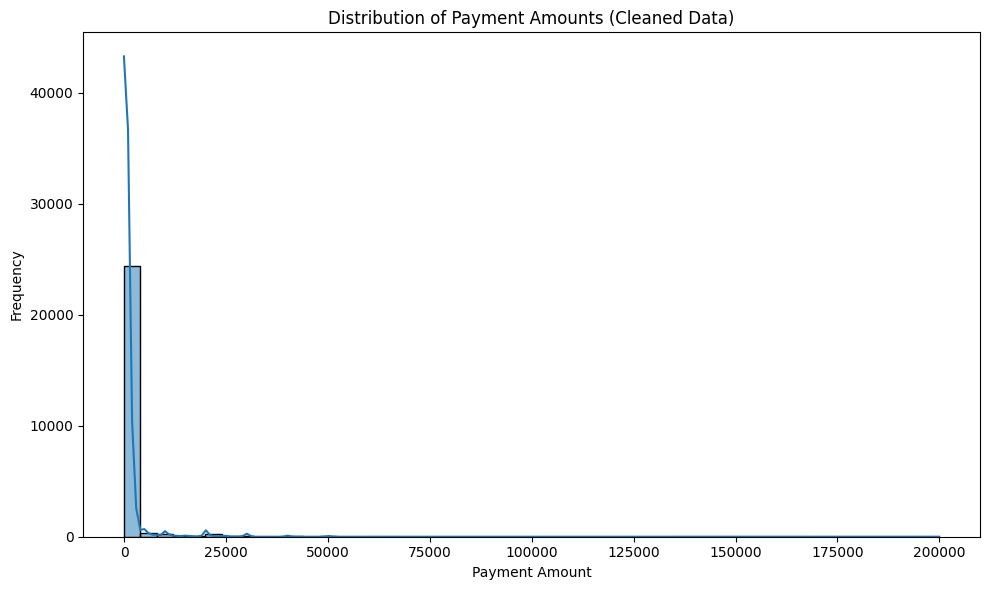

In [70]:
# Distribution of Payment Amounts
plt.figure(figsize=(10, 6))
sns.histplot(merged_cleaned_df['payment_amt'], bins=50, kde=True)
plt.title('Distribution of Payment Amounts (Cleaned Data)')
plt.xlabel('Payment Amount')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


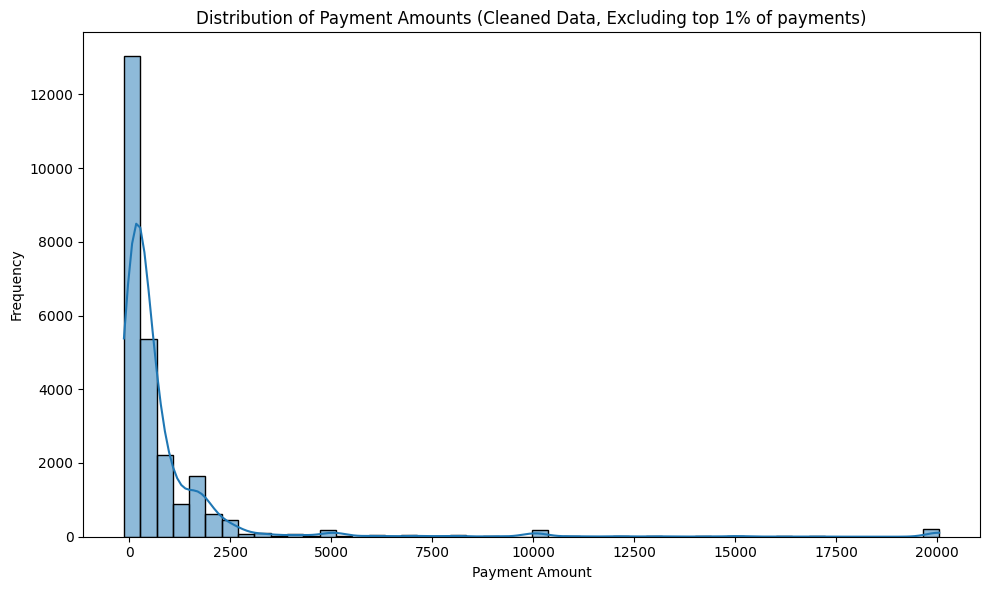

In [71]:
# Without the top 1% of payments
upper_limit = merged_cleaned_df['payment_amt'].quantile(0.99)
filtered_payments = merged_cleaned_df[merged_cleaned_df['payment_amt'] <= upper_limit]

plt.figure(figsize=(10, 6))
sns.histplot(filtered_payments['payment_amt'], bins=50, kde=True)
plt.title('Distribution of Payment Amounts (Cleaned Data, Excluding top 1% of payments)')
plt.xlabel('Payment Amount')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

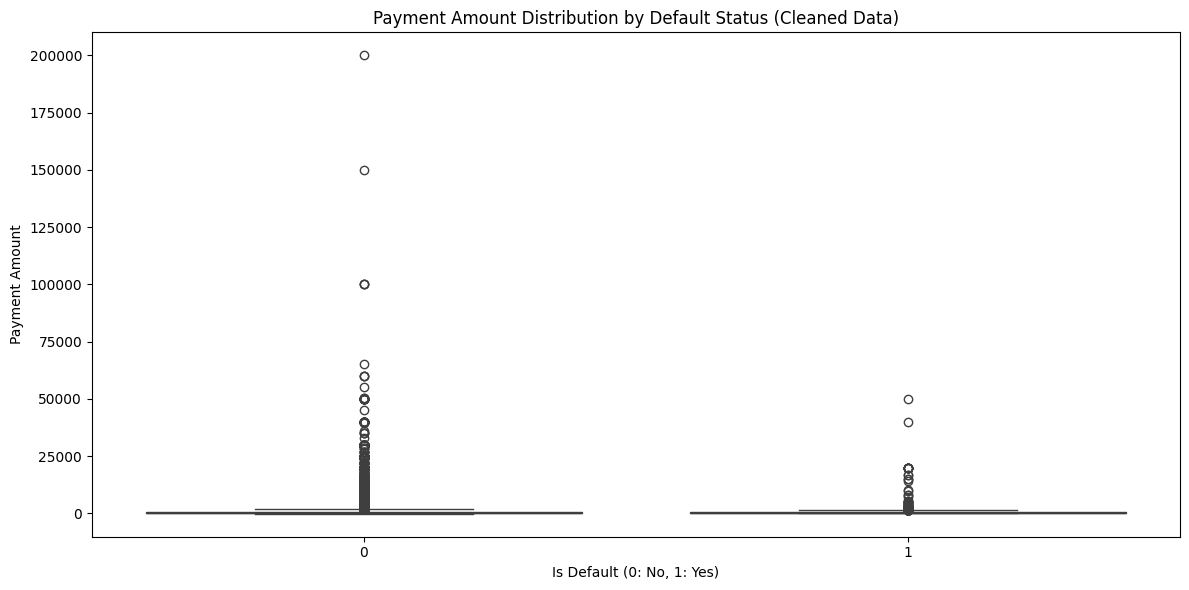

In [72]:
# Distribution of Payment Amounts between those that were defaulted and those that were paid
plt.figure(figsize=(12, 6))
sns.boxplot(x='is_default', y='payment_amt', data=merged_cleaned_df)
plt.title('Payment Amount Distribution by Default Status (Cleaned Data)')
plt.xlabel('Is Default (0: No, 1: Yes)')
plt.ylabel('Payment Amount')
plt.tight_layout()
plt.show()


Default rates by Entity Type (from Cleaned Data):
| entity_type                    | total_transactions   | defaults   | default_rate   |
|:-------------------------------|:---------------------|:-----------|:---------------|
| Discretionary Investment Trust | 59                   | 14         | 23.7288        |
| Australian Public Company      | 128                  | 16         | 12.5           |
| Discretionary Trading Trust    | 187                  | 21         | 11.2299        |
| Individual/Sole Trader         | 9418                 | 901        | 9.56679        |
| Australian Private Company     | 14828                | 1226       | 8.26814        |
| Hybrid Trust                   | 32                   | 2          | 6.25           |
| Family Partnership             | 736                  | 33         | 4.4837         |
| Other Partnership              | 135                  | 6          | 4.44444        |
| Australian Proprietary Company | 4                    | 0          

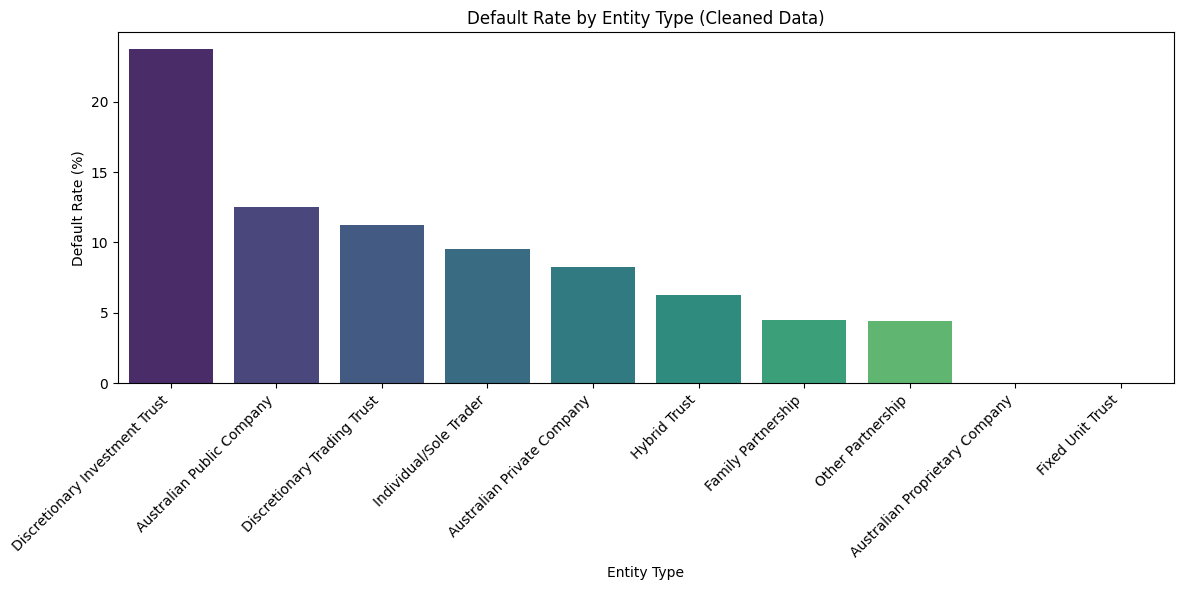

In [73]:
entity_type_defaults_cleaned = merged_cleaned_df.groupby('entity_type').agg(
    total_transactions=('is_default', 'count'),
    defaults=('is_default', 'sum')
).reset_index()
entity_type_defaults_cleaned['default_rate'] = (entity_type_defaults_cleaned['defaults'] / entity_type_defaults_cleaned['total_transactions']) * 100
entity_type_defaults_cleaned = entity_type_defaults_cleaned.sort_values(by='default_rate', ascending=False)

print("\nDefault rates by Entity Type (from Cleaned Data):")
print(entity_type_defaults_cleaned.to_markdown(index=False, numalign="left", stralign="left"))

plt.figure(figsize=(12, 6))
sns.barplot(x='entity_type', y='default_rate', data=entity_type_defaults_cleaned, hue='entity_type', palette='viridis', legend=False)
plt.title('Default Rate by Entity Type (Cleaned Data)')
plt.xlabel('Entity Type')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Default rates by Client Age Group (Cleaned Data):
| client_age_group   | total_transactions   | defaults   | default_rate   |
|:-------------------|:---------------------|:-----------|:---------------|
| 3-4 Years          | 2688                 | 317        | 11.7932        |
| 4-5 Years          | 2326                 | 267        | 11.4789        |
| 2-3 Years          | 2228                 | 253        | 11.3555        |
| 11-12 Years        | 1157                 | 125        | 10.8038        |
| 9-10 Years         | 1063                 | 113        | 10.6303        |
| 5-6 Years          | 1728                 | 176        | 10.1852        |
| 19-20 Years        | 372                  | 31         | 8.33333        |
| 16-17 Years        | 452                  | 37         | 8.18584        |
| 18-19 Years        | 2237                 | 174        | 7.77827        |
| 8-9 Years          | 1080                 | 84         | 7.77778        |
| 6-7 Years          | 1707          

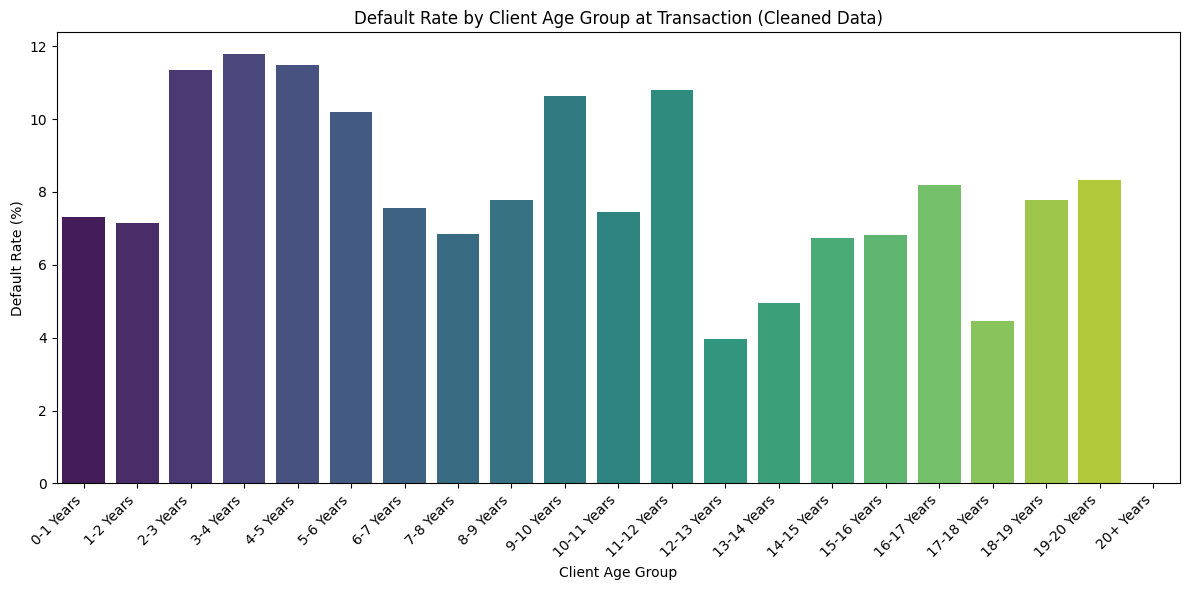

In [74]:
max_year = 20
age_bins = list(range(0, max_year)) + [max_year, float('inf')]
age_labels = [f"{i}-{i+1} Years" for i in range(0, max_year)] + ["20+ Years"]

merged_cleaned_df['client_age_group'] = pd.cut(
    merged_cleaned_df['client_age_at_transaction'],
    bins=age_bins,
    labels=age_labels,
    right=False
)

age_group_defaults_cleaned = merged_cleaned_df.groupby('client_age_group', observed=True).agg(
    total_transactions=('is_default', 'count'),
    defaults=('is_default', 'sum')
).reset_index()
age_group_defaults_cleaned['default_rate'] = (age_group_defaults_cleaned['defaults'] / age_group_defaults_cleaned['total_transactions']) * 100
age_group_defaults_cleaned = age_group_defaults_cleaned.sort_values(by='default_rate', ascending=False)

print("\nDefault rates by Client Age Group (Cleaned Data):")
print(age_group_defaults_cleaned.to_markdown(index=False, numalign="left", stralign="left"))

plt.figure(figsize=(12, 6))
sns.barplot(x='client_age_group', y='default_rate', data=age_group_defaults_cleaned, hue='client_age_group', palette='viridis', legend=False, dodge=False)
plt.title('Default Rate by Client Age Group at Transaction (Cleaned Data)')
plt.xlabel('Client Age Group')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Default rates by Client Age Group (Cleaned Data):
| client_age_group   | total_transactions   | defaults   | default_rate   |
|:-------------------|:---------------------|:-----------|:---------------|
| 0-3 Years          | 6241                 | 665        | 10.6553        |
| 4-6 Years          | 5761                 | 572        | 9.92883        |
| 19+ Years          | 372                  | 31         | 8.33333        |
| 7-9 Years          | 3415                 | 284        | 8.31625        |
| 10-12 Years        | 3250                 | 250        | 7.69231        |
| 16-18 Years        | 4369                 | 286        | 6.54612        |
| 13-15 Years        | 2151                 | 131        | 6.09019        |


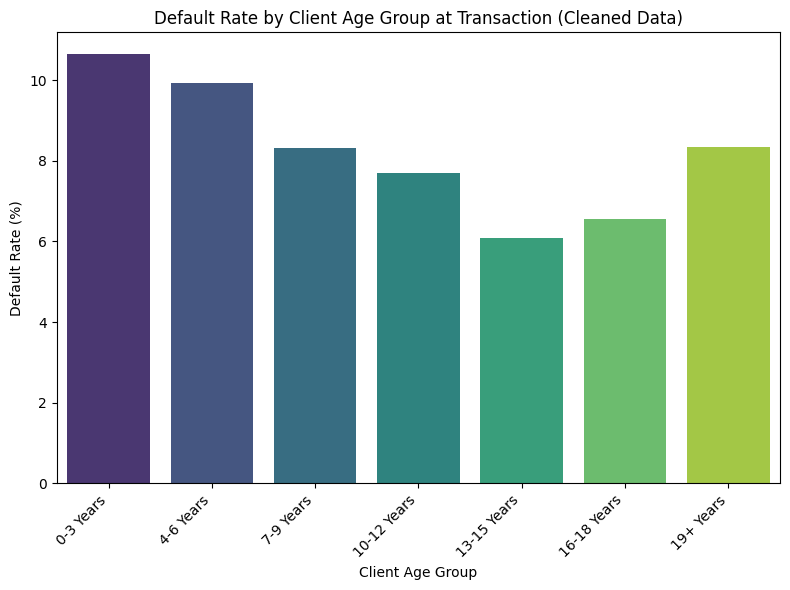

In [75]:
age_bins = [0, 4, 7, 10, 13, 16, 19, float('inf')]
age_labels = ["0-3 Years", "4-6 Years", "7-9 Years", "10-12 Years", "13-15 Years", "16-18 Years", "19+ Years"]

merged_cleaned_df['client_age_group'] = pd.cut(
    merged_cleaned_df['client_age_at_transaction'],
    bins=age_bins,
    labels=age_labels,
    right=False
)

age_group_defaults_cleaned = merged_cleaned_df.groupby('client_age_group', observed=True).agg(
    total_transactions=('is_default', 'count'),
    defaults=('is_default', 'sum')
).reset_index()
age_group_defaults_cleaned['default_rate'] = (age_group_defaults_cleaned['defaults'] / age_group_defaults_cleaned['total_transactions']) * 100
age_group_defaults_cleaned = age_group_defaults_cleaned.sort_values(by='default_rate', ascending=False)

print("\nDefault rates by Client Age Group (Cleaned Data):")
print(age_group_defaults_cleaned.to_markdown(index=False, numalign="left", stralign="left"))

plt.figure(figsize=(8, 6))
sns.barplot(x='client_age_group', y='default_rate', data=age_group_defaults_cleaned, hue='client_age_group', palette='viridis', legend=False, dodge=False)
plt.title('Default Rate by Client Age Group at Transaction (Cleaned Data)')
plt.xlabel('Client Age Group')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Default rates by Month (from Cleaned Data):
| transaction_month   | total_transactions   | defaults   | default_rate   |
|:--------------------|:---------------------|:-----------|:---------------|
| 1                   | 1871                 | 165        | 8.81881        |
| 2                   | 1905                 | 188        | 9.86877        |
| 3                   | 1917                 | 164        | 8.55503        |
| 4                   | 2272                 | 222        | 9.77113        |
| 5                   | 2430                 | 202        | 8.31276        |
| 6                   | 2469                 | 209        | 8.46497        |
| 7                   | 4129                 | 364        | 8.81569        |
| 8                   | 1759                 | 193        | 10.9721        |
| 9                   | 1653                 | 140        | 8.46945        |
| 10                  | 1742                 | 148        | 8.49598        |
| 11                  | 1751   

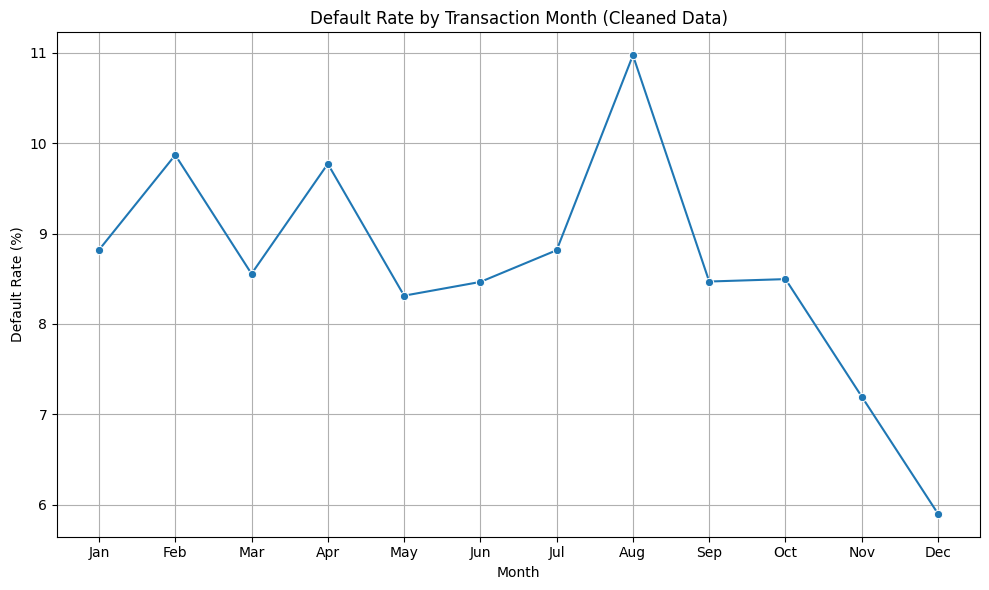

In [78]:
# Temporal Deafults (Month)
monthly_defaults_cleaned = merged_cleaned_df.groupby('transaction_month').agg(
    total_transactions=('is_default', 'count'),
    defaults=('is_default', 'sum')
).reset_index()
monthly_defaults_cleaned['default_rate'] = (monthly_defaults_cleaned['defaults'] / monthly_defaults_cleaned['total_transactions']) * 100

print("\nDefault rates by Month (from Cleaned Data):")
print(monthly_defaults_cleaned.sort_values(by='transaction_month').to_markdown(index=False, numalign="left", stralign="left"))

plt.figure(figsize=(10, 6))
sns.lineplot(x='transaction_month', y='default_rate', data=monthly_defaults_cleaned, marker='o')
plt.title('Default Rate by Transaction Month (Cleaned Data)')
plt.xlabel('Month')
plt.ylabel('Default Rate (%)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()


Default rates by Quarter (from Cleaned Data):
| transaction_quarter   | total_transactions   | defaults   | default_rate   |
|:----------------------|:---------------------|:-----------|:---------------|
| 1                     | 5693                 | 517        | 9.08133        |
| 2                     | 7171                 | 633        | 8.82722        |
| 3                     | 7541                 | 697        | 9.24281        |
| 4                     | 5154                 | 372        | 7.21769        |


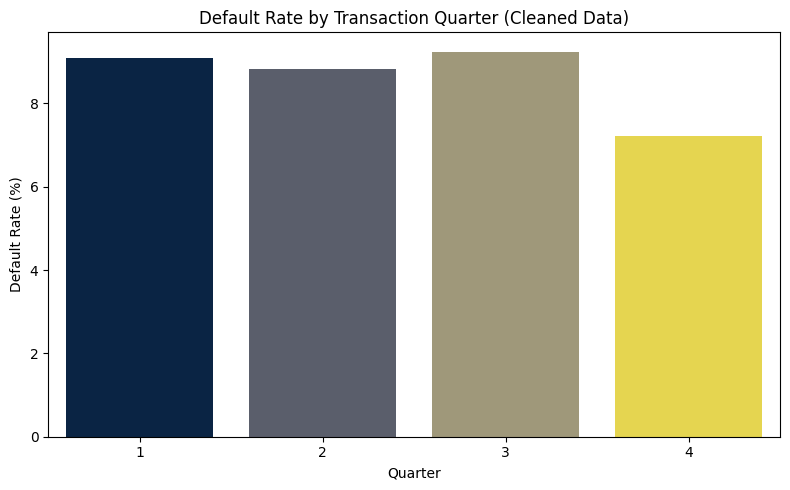

In [77]:
# Temporal Deafults (Quarter)
quarterly_defaults_cleaned = merged_cleaned_df.groupby('transaction_quarter').agg(
    total_transactions=('is_default', 'count'),
    defaults=('is_default', 'sum')
).reset_index()
quarterly_defaults_cleaned['default_rate'] = (quarterly_defaults_cleaned['defaults'] / quarterly_defaults_cleaned['total_transactions']) * 100

print("\nDefault rates by Quarter (from Cleaned Data):")
print(quarterly_defaults_cleaned.sort_values(by='transaction_quarter').to_markdown(index=False, numalign="left", stralign="left"))

plt.figure(figsize=(8, 5))
sns.barplot(x='transaction_quarter', y='default_rate', data=quarterly_defaults_cleaned, hue='transaction_quarter', palette='cividis', legend=False)
plt.title('Default Rate by Transaction Quarter (Cleaned Data)')
plt.xlabel('Quarter')
plt.ylabel('Default Rate (%)')
plt.tight_layout()
plt.show()


Default rates by Payment Lag Group (from Cleaned Data):
| payment_lag_group     | total_transactions   | defaults   | default_rate   |
|:----------------------|:---------------------|:-----------|:---------------|
| 180+ Days             | 5                    | 3          | 60             |
| 91-180 Days           | 12                   | 4          | 33.3333        |
| 1-7 Days              | 3372                 | 1071       | 31.7616        |
| Same Day/Prev Day (0) | 12596                | 1113       | 8.83614        |
| 61-90 Days            | 37                   | 2          | 5.40541        |
| 8-14 Days             | 434                  | 6          | 1.38249        |
| 31-60 Days            | 2757                 | 6          | 0.217628       |
| 15-30 Days            | 4703                 | 3          | 0.0637891      |


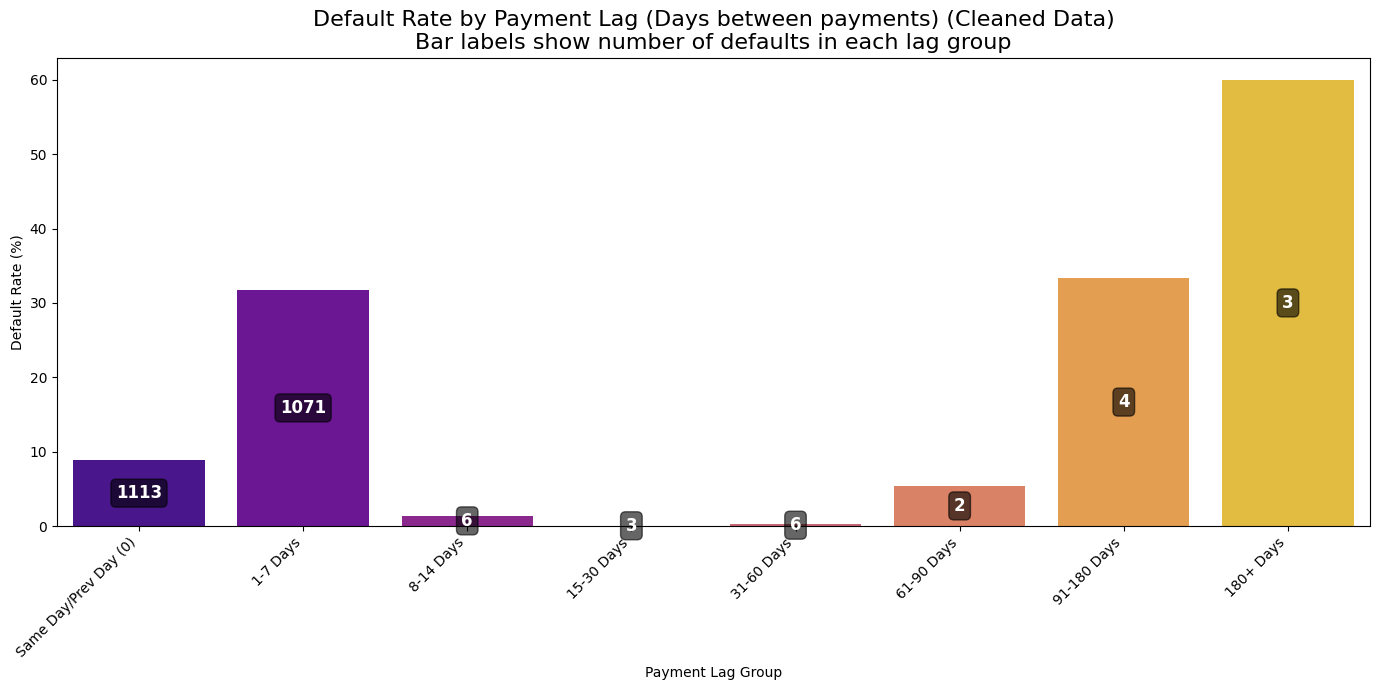

In [79]:
# Default rates by Payment Lag Group
# Create lag bins
lag_bins = [-1, 0, 7, 14, 30, 60, 90, 180, merged_cleaned_df['payment_lag_days'].max() + 1]
lag_labels = ['Same Day/Prev Day (0)', '1-7 Days', '8-14 Days', '15-30 Days', '31-60 Days', '61-90 Days', '91-180 Days', '180+ Days']

# Exclude NaN values from payment_lag_days as they are first payments of a contract
lag_analysis_df_cleaned = merged_cleaned_df.dropna(subset=['payment_lag_days']).copy()
lag_analysis_df_cleaned['payment_lag_group'] = pd.cut(
    lag_analysis_df_cleaned['payment_lag_days'],
    bins=lag_bins,
    labels=lag_labels,
    right=True
)

lag_defaults_cleaned = lag_analysis_df_cleaned.groupby('payment_lag_group', observed=False).agg(
    total_transactions=('is_default', 'count'),
    defaults=('is_default', 'sum')
).reset_index()
lag_defaults_cleaned['default_rate'] = (lag_defaults_cleaned['defaults'] / lag_defaults_cleaned['total_transactions']) * 100

print("\nDefault rates by Payment Lag Group (from Cleaned Data):")
print(lag_defaults_cleaned.sort_values(by='default_rate', ascending=False).to_markdown(index=False, numalign="left", stralign="left"))

plt.figure(figsize=(14, 7))
ax = sns.barplot(
    x='payment_lag_group',
    y='default_rate',
    data=lag_defaults_cleaned,
    hue='payment_lag_group',
    palette='plasma'
)
plt.title('Default Rate by Payment Lag (Days between payments) (Cleaned Data)\nBar labels show number of defaults in each lag group', fontsize=16)
plt.xlabel('Payment Lag Group')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Annotate each bar with the raw frequency (defaults)
for i, row in lag_defaults_cleaned.iterrows():
    ax.text(
        i,
        row['default_rate'] / 2,
        f"{int(row['defaults'])}",
        ha='center', va='center',
        color='white', fontweight='bold', fontsize=12,
        bbox=dict(facecolor='black', alpha=0.6, boxstyle='round,pad=0.3')
    )

plt.show()

There seem to be a large number of Same Day/Previous Day defaults. It could be that the payment defaults, and they quickly turnaround and rectify this issue, and make the payment soon after the issue is detected.

## ⚒️ Refining Data

The conditions for a "rectified" payment:
1. Current transaction's original payment_code is 'DEFAULT'
2. Next payment exists (not NaN for next_payment_code_cc)
3. Next payment's 'is_default' status is 0 (meaning it was successful/non-default)
4. Next payment's amount is the same as the current payment's amount

In [80]:
import numpy as np


Number of rectifying payments by hour after a defaulted payment (first 20 rows):
| hours_to_next_rounded   | num_rectifying_payments   |
|:------------------------|:--------------------------|
| 0                       | 51                        |
| 24                      | 30                        |
| 48                      | 8                         |
| 72                      | 17                        |
| 96                      | 12                        |
| 120                     | 9                         |
| 143                     | 1                         |
| 144                     | 112                       |
| 168                     | 40                        |
| 169                     | 4                         |
| 192                     | 5                         |
| 193                     | 2                         |
| 216                     | 3                         |
| 240                     | 4                         |
| 241                 

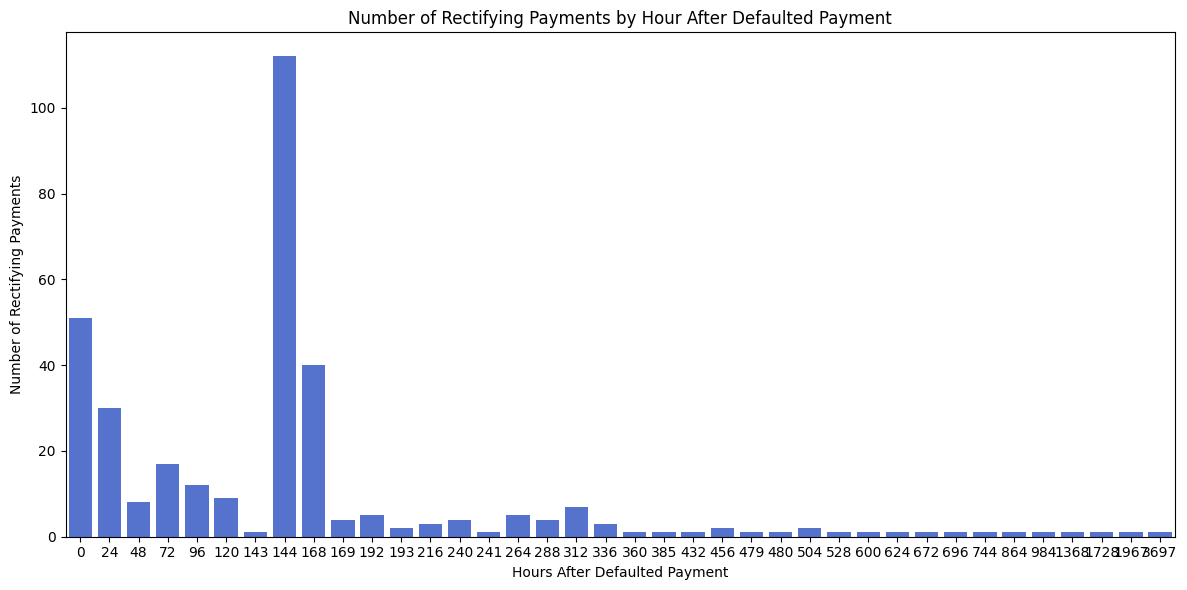

In [81]:
merged_df_rectify_hour = merged_cleaned_df.copy()
merged_df_rectify_hour.sort_values(by=['client_id', 'contract_id', 'transaction_date'], inplace=True)

# Create next transaction columns within each client-contract group
merged_df_rectify_hour['next_payment_code_cc'] = merged_df_rectify_hour.groupby(['client_id', 'contract_id'])['payment_code'].shift(-1)
merged_df_rectify_hour['next_transaction_date_cc'] = merged_df_rectify_hour.groupby(['client_id', 'contract_id'])['transaction_date'].shift(-1)
merged_df_rectify_hour['next_payment_amt_cc'] = merged_df_rectify_hour.groupby(['client_id', 'contract_id'])['payment_amt'].shift(-1)
merged_df_rectify_hour['next_is_default_cc'] = merged_df_rectify_hour.groupby(['client_id', 'contract_id'])['is_default'].shift(-1)

# Calculate time difference to next transaction in hours
merged_df_rectify_hour['hours_to_next'] = (
    (merged_df_rectify_hour['next_transaction_date_cc'] - merged_df_rectify_hour['transaction_date']).dt.total_seconds() / 3600
)

# Only consider rows where current payment is DEFAULT and next payment is a successful rectification (same amount, not default)
rectified_mask = (
    (merged_df_rectify_hour['payment_code'] == 'DEFAULT') &
    (merged_df_rectify_hour['next_payment_code_cc'].notna()) &
    (merged_df_rectify_hour['next_is_default_cc'] == 0) &
    (merged_df_rectify_hour['next_payment_amt_cc'] == merged_df_rectify_hour['payment_amt'])
)

rectified_df = merged_df_rectify_hour[rectified_mask].copy()
rectified_df['hours_to_next_rounded'] = rectified_df['hours_to_next'].round().astype(int)

# Count number of rectifying payments for each hour after a default
rectify_hour_counts = rectified_df.groupby('hours_to_next_rounded').size().reset_index(name='num_rectifying_payments')

print("\nNumber of rectifying payments by hour after a defaulted payment (first 20 rows):")
print(rectify_hour_counts.head(20).to_markdown(index=False, numalign="left", stralign="left"))

plt.figure(figsize=(12, 6))
sns.barplot(x='hours_to_next_rounded', y='num_rectifying_payments', data=rectify_hour_counts, color='royalblue')
plt.title('Number of Rectifying Payments by Hour After Defaulted Payment')
plt.xlabel('Hours After Defaulted Payment')
plt.ylabel('Number of Rectifying Payments')
plt.tight_layout()
plt.show()

Feature Engineering an _"hours_until_rectified"_ flag

In [84]:
merged_df_round2 = merged_cleaned_df.copy()
print(f"Further enriching and refining the dataset")
print(f"-> Initial shape of `merged_df_round2`: {merged_df_round2.shape}")

# Ensure the DataFrame is sorted by client_id, contract_id, and transaction_date
# This is crucial for accurate 'shift' operations within groups
merged_df_round2.sort_values(by=['client_id', 'contract_id', 'transaction_date'], inplace=True)

# Create temporary columns for the *next* transaction's details within the same client-contract pair
merged_df_round2['next_payment_code_cc'] = merged_df_round2.groupby(['client_id', 'contract_id'])['payment_code'].shift(-1)
merged_df_round2['next_transaction_date_cc'] = merged_df_round2.groupby(['client_id', 'contract_id'])['transaction_date'].shift(-1)
merged_df_round2['next_payment_amt_cc'] = merged_df_round2.groupby(['client_id', 'contract_id'])['payment_amt'].shift(-1)
merged_df_round2['next_is_default_cc'] = merged_df_round2.groupby(['client_id', 'contract_id'])['is_default'].shift(-1)


# Calculate the time difference to the next transaction for the same client-contract pair
merged_df_round2['time_to_next_transaction_cc'] = merged_df_round2['next_transaction_date_cc'] - merged_df_round2['transaction_date']

# Convert timedelta to total hours
merged_df_round2['hours_to_next_cc'] = merged_df_round2['time_to_next_transaction_cc'].dt.total_seconds() / 3600


# Define the conditions for a "rectified" payment
# 1. Current transaction's original payment_code is 'DEFAULT'
# 2. Next payment exists (not NaN for next_payment_code_cc)
# 3. Next payment's 'is_default' status is 0 (meaning it was successful/non-default after initial refinement)
# 4. Next payment's amount is the same as the current payment's amount
rectified_conditions = (
    (merged_df_round2['payment_code'] == 'DEFAULT') & # Check original payment_code for DEFAULT
    (merged_df_round2['next_payment_code_cc'].notna()) & # Ensure there is a next payment
    (merged_df_round2['next_is_default_cc'] == 0) & # The next payment was not a default (after initial refinement)
    (merged_df_round2['next_payment_amt_cc'] == merged_df_round2['payment_amt']) # Amounts match
)

# Initialize the new column 'hours_until_rectified'
# For transactions that are NOT defaults or don't meet rectification criteria, set to np.inf
merged_df_round2['hours_until_rectified'] = np.inf

# For transactions that ARE defaults and meet the rectification criteria, set to the calculated hours
merged_df_round2.loc[rectified_conditions, 'hours_until_rectified'] = \
    merged_df_round2.loc[rectified_conditions, 'hours_to_next_cc']

num_rectified_defaults_round2 = merged_df_round2[merged_df_round2['hours_until_rectified'] != np.inf].shape[0]
print(f"Created 'hours_until_rectified' flag.")
print(f"-> Found {num_rectified_defaults_round2} instances of defaults that were rectified with matching amounts.")
print("-> For non-rectified defaults or non-default transactions, 'hours_until_rectified' is set to infinity (np.inf).")


# Clean up the temporary columns
merged_df_round2.drop(columns=[
    'next_payment_code_cc',
    'next_transaction_date_cc',
    'next_payment_amt_cc',
    'next_is_default_cc',
    'time_to_next_transaction_cc',
    'hours_to_next_cc'
], inplace=True, errors='ignore')

print("\n`merged_df_round2` after adding 'hours_until_rectified' flag - first 10 rows:")
# Display relevant columns to confirm the new flag
display_cols_flag_round2 = [
    'client_id', 'contract_id', 'transaction_date', 'payment_code', 'payment_amt', 'is_default',
    'hours_until_rectified'
]
print(merged_df_round2[display_cols_flag_round2].head(10).to_markdown(index=False, numalign="left", stralign="left"))

rectified_payments_only = merged_df_round2[merged_df_round2['hours_until_rectified'] != np.inf]

if not rectified_payments_only.empty:
    max_rectification_hours = rectified_payments_only['hours_until_rectified'].max()

    # Convert total hours into days and remaining hours
    max_days = int(max_rectification_hours // 24)
    max_remaining_hours = max_rectification_hours % 24

    print(f"\n-> Maximum rectification time observed: {max_days} days and {max_remaining_hours:.2f} hours.")
else:
    print("\n-> No rectified payments found to calculate maximum rectification time.")

Further enriching and refining the dataset
-> Initial shape of `merged_df_round2`: (25559, 15)
Created 'hours_until_rectified' flag.
-> Found 339 instances of defaults that were rectified with matching amounts.
-> For non-rectified defaults or non-default transactions, 'hours_until_rectified' is set to infinity (np.inf).

`merged_df_round2` after adding 'hours_until_rectified' flag - first 10 rows:
| client_id   | contract_id   | transaction_date    | payment_code   | payment_amt   | is_default   | hours_until_rectified   |
|:------------|:--------------|:--------------------|:---------------|:--------------|:-------------|:------------------------|
| 1           | 927           | 2017-11-22 17:08:16 | PAYMENT        | 5050.04       | 0            | inf                     |
| 1           | 927           | 2017-11-22 17:08:16 | PAYMENT        | 50            | 0            | inf                     |
| 1           | 927           | 2017-11-26 17:08:15 | PAYMENT        | 66.66         |

## 📈 Round 2 of Analysis

Does our data look different when ignoring defaults that are _rectified_ in less than 168hrs (7days)?

In [86]:
constant_hours_threshold = 168

# Filter for rectified payments that are within the specified constant_hours_threshold
rectified_within_threshold = merged_df_round2[
    (merged_df_round2['hours_until_rectified'] != np.inf) &
    (merged_df_round2['hours_until_rectified'] < constant_hours_threshold)
]

num_rectified_payments_within_threshold = rectified_within_threshold.shape[0]

print(f"\nNumber of rectifying payments that happened within {constant_hours_threshold}hrs: {num_rectified_payments_within_threshold}")


Number of rectifying payments that happened within 168hrs: 242


In [90]:
# Create the new 'is_default_round2' column in merged_df_round2
# Initialise it with the original 'is_default' values
merged_df_round2['is_default_round2'] = merged_df_round2['is_default']

# Identify defaults that are rectified within the constant_hours_threshold
# These are the ones where original 'is_default' was 1, and 'hours_until_rectified' is within the threshold.
rectified_within_threshold_mask = (
    (merged_df_round2['is_default'] == 1) &
    (merged_df_round2['hours_until_rectified'] != np.inf) &
    (merged_df_round2['hours_until_rectified'] < constant_hours_threshold)
)

# For these specific cases, set 'is_default_round2' to 0
merged_df_round2.loc[rectified_within_threshold_mask, 'is_default_round2'] = 0

print(f"\nCreated 'is_default_round2' column in `merged_df_round2`.")
print(f"-> Defaults rectified within {constant_hours_threshold} hours are now considered non-defaults (0) in this new flag.")

# Optional: Check how many defaults changed their status
num_original_defaults = merged_df_round2['is_default'].sum()
num_defaults_round2 = merged_df_round2['is_default_round2'].sum()
num_defaults_reclassified = num_original_defaults - num_defaults_round2
print("\nDefault reclassifications:")
print(f"-> Original number of defaults: {num_original_defaults}")
print(f"-> Number of defaults in Round 2 Analysis (after reclassification): {num_defaults_round2}")
print(f"-> Number of defaults reclassified as non-defaults (rectified within {constant_hours_threshold} hours): {num_defaults_reclassified}")


Created 'is_default_round2' column in `merged_df_round2`.
-> Defaults rectified within 168 hours are now considered non-defaults (0) in this new flag.

Default reclassifications:
-> Original number of defaults: 2219
-> Number of defaults in Round 2 Analysis (after reclassification): 1977
-> Number of defaults reclassified as non-defaults (rectified within 168 hours): 242


Here is some unchaged data:
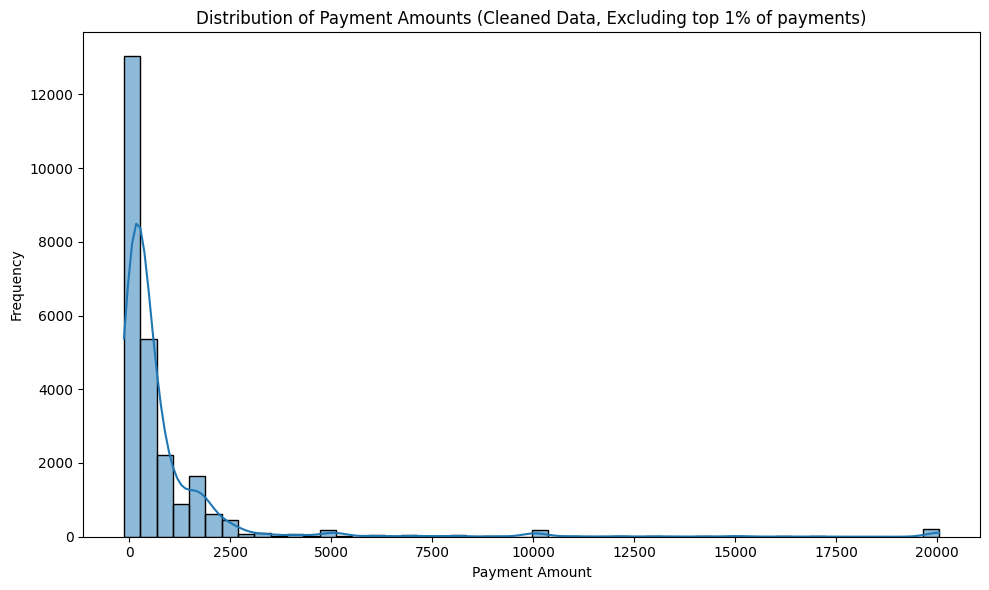

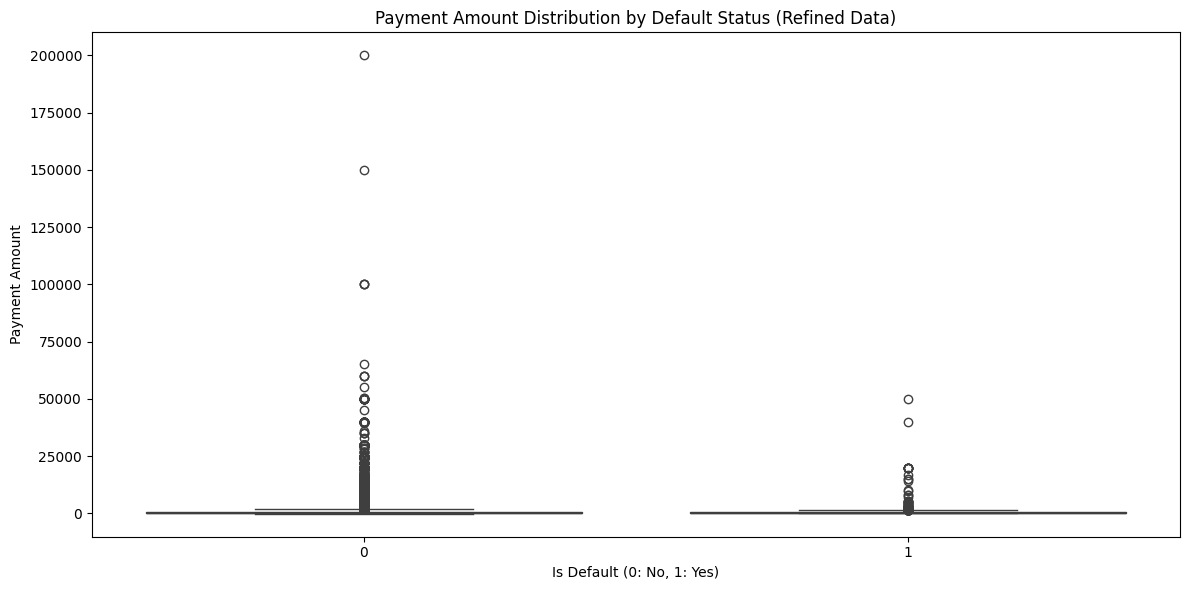

In [92]:
# Distribution of Payment Amounts between those that were defaulted and not rectified and those that were paid
plt.figure(figsize=(12, 6))
sns.boxplot(x='is_default_round2', y='payment_amt', data=merged_df_round2)
plt.title('Payment Amount Distribution by Default Status (Refined Data)')
plt.xlabel('Is Default (0: No, 1: Yes)')
plt.ylabel('Payment Amount')
plt.tight_layout()
plt.show()

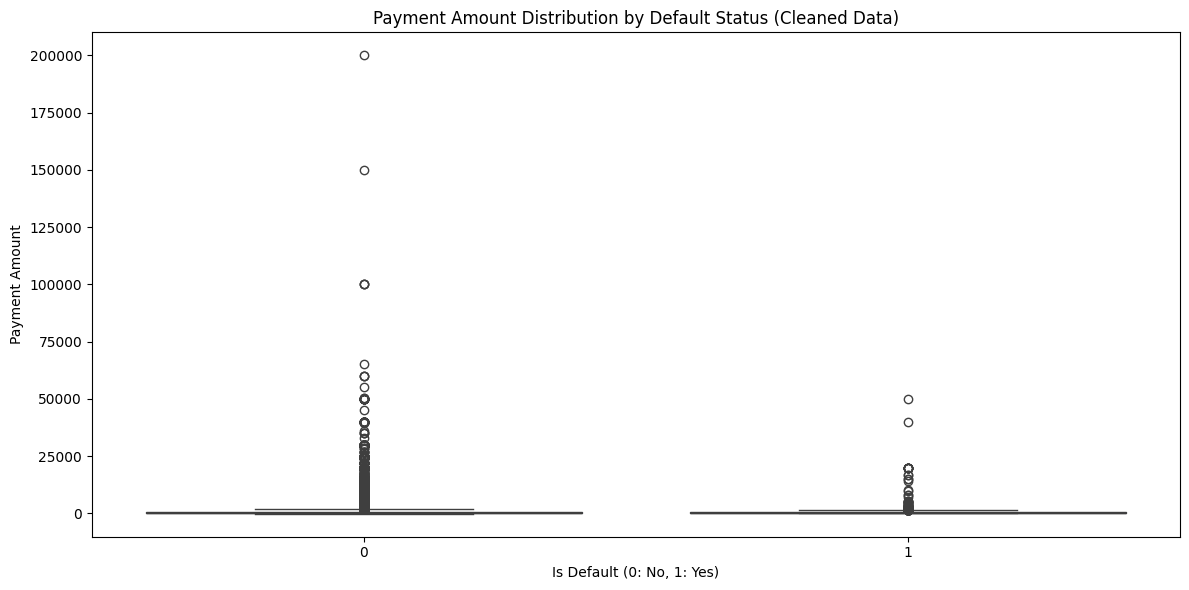


Created 'is_default_round2' column in `merged_df_round2`.
Defaults rectified within 168 hours are now considered non-defaults (0) in this new flag.

`merged_df_round2` with 'is_default_round2' - first 10 rows (focus on default related):
| client_id   | contract_id   | transaction_date    | payment_code   | payment_amt   | is_default   | hours_until_rectified   | is_default_round2   |
|:------------|:--------------|:--------------------|:---------------|:--------------|:-------------|:------------------------|:--------------------|
| 1           | 927           | 2017-11-22 17:08:16 | PAYMENT        | 5050.04       | 0            | inf                     | 0                   |
| 1           | 927           | 2017-11-22 17:08:16 | PAYMENT        | 50            | 0            | inf                     | 0                   |
| 1           | 927           | 2017-11-26 17:08:15 | PAYMENT        | 66.66         | 0            | inf                     | 0                   |
| 1         

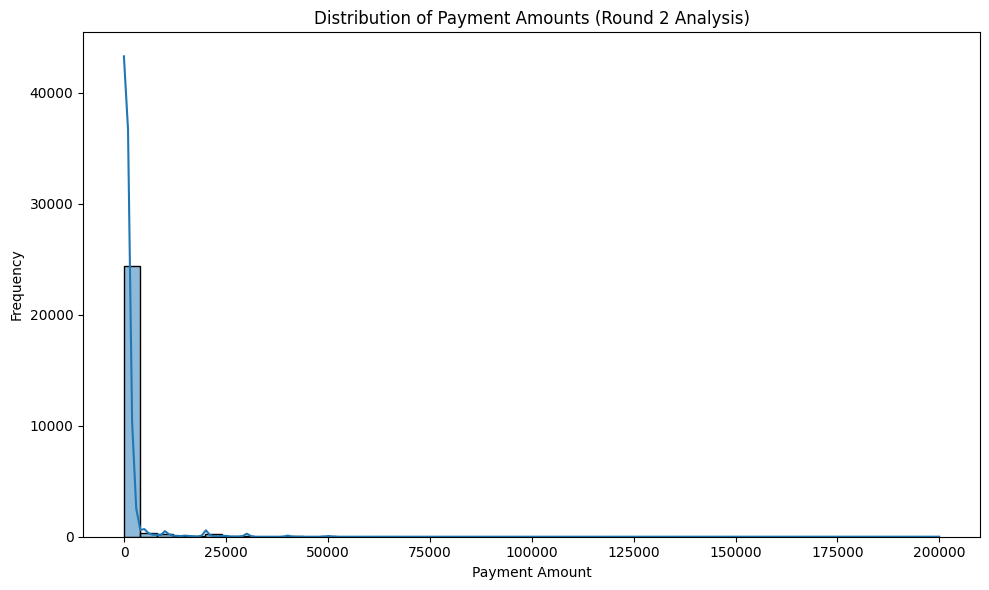

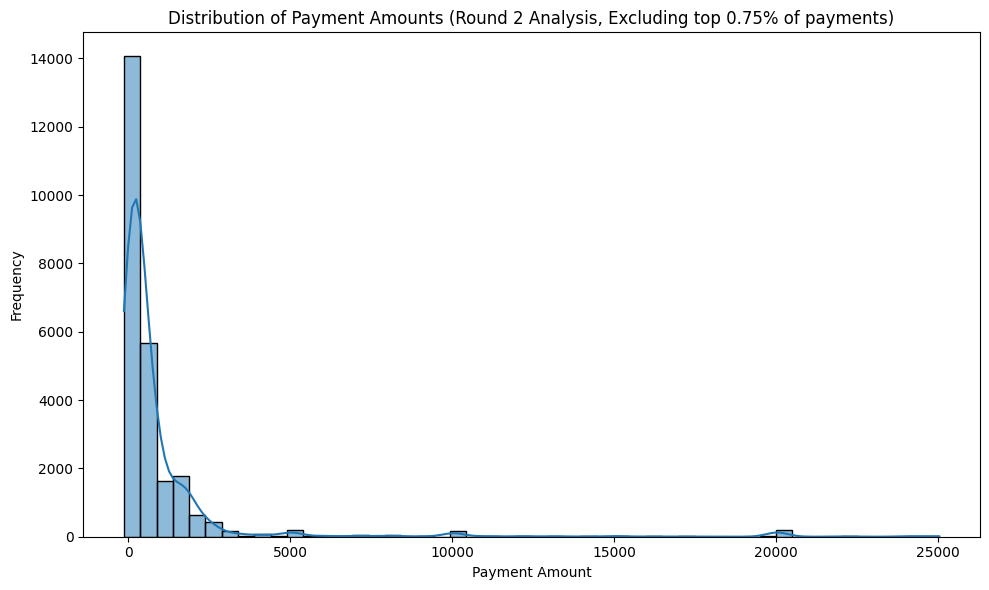

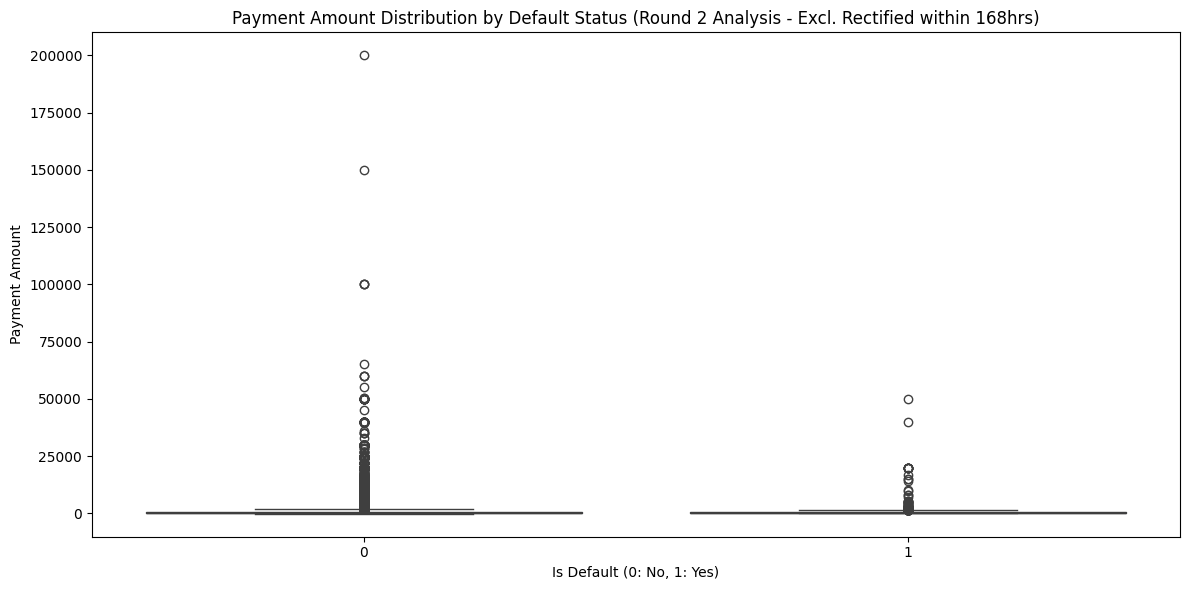


Default rates by Entity Type (Round 2 Analysis - Excl. Rectified within 168hrs):
| entity_type                    | total_transactions   | defaults   | default_rate   |
|:-------------------------------|:---------------------|:-----------|:---------------|
| Discretionary Investment Trust | 59                   | 13         | 22.0339        |
| Australian Public Company      | 128                  | 14         | 10.9375        |
| Discretionary Trading Trust    | 187                  | 18         | 9.62567        |
| Individual/Sole Trader         | 9418                 | 789        | 8.37757        |
| Australian Private Company     | 14828                | 1107       | 7.46561        |
| Hybrid Trust                   | 32                   | 2          | 6.25           |
| Other Partnership              | 135                  | 6          | 4.44444        |
| Family Partnership             | 736                  | 28         | 3.80435        |
| Australian Proprietary Company | 4  

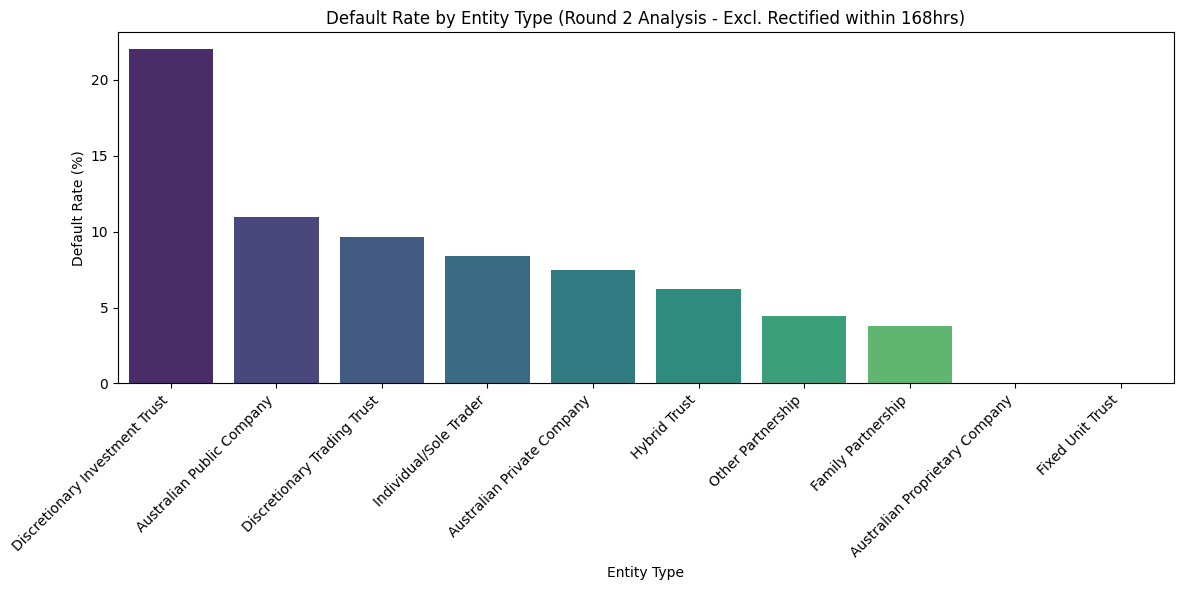


Default rates by Client Age Group (Round 2 Analysis - Excl. Rectified within 168hrs):
| client_age_group   | total_transactions   | defaults   | default_rate   |
|:-------------------|:---------------------|:-----------|:---------------|
| 0-3 Years          | 6241                 | 598        | 9.5818         |
| 4-6 Years          | 5761                 | 509        | 8.83527        |
| 19+ Years          | 372                  | 28         | 7.52688        |
| 7-9 Years          | 3415                 | 254        | 7.43777        |
| 10-12 Years        | 3250                 | 217        | 6.67692        |
| 16-18 Years        | 4369                 | 256        | 5.85946        |
| 13-15 Years        | 2151                 | 115        | 5.34635        |


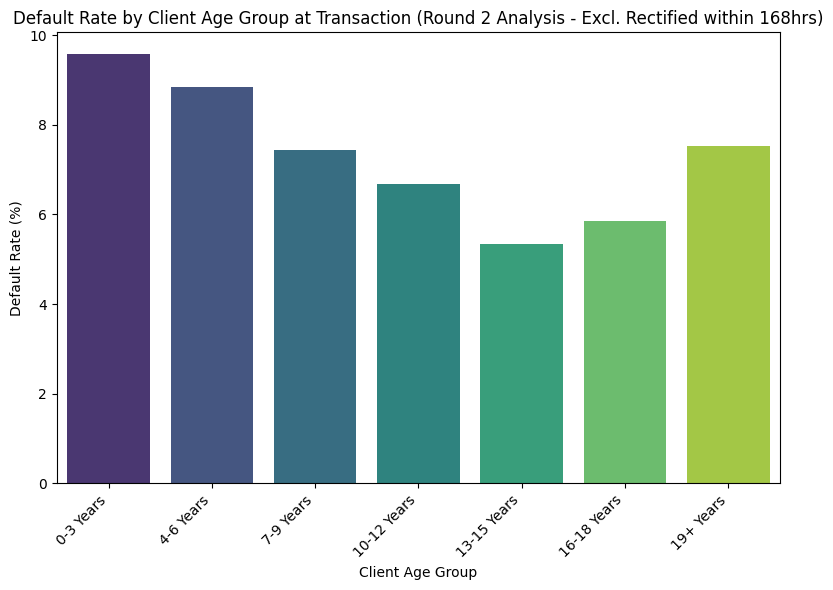


Default rates by Month (Round 2 Analysis - Excl. Rectified within 168hrs):
| transaction_month   | total_transactions   | defaults   | default_rate   |
|:--------------------|:---------------------|:-----------|:---------------|
| 1                   | 1871                 | 150        | 8.0171         |
| 2                   | 1905                 | 166        | 8.71391        |
| 3                   | 1917                 | 144        | 7.51174        |
| 4                   | 2272                 | 198        | 8.71479        |
| 5                   | 2430                 | 173        | 7.11934        |
| 6                   | 2469                 | 180        | 7.2904         |
| 7                   | 4129                 | 315        | 7.62897        |
| 8                   | 1759                 | 172        | 9.77828        |
| 9                   | 1653                 | 133        | 8.04598        |
| 10                  | 1742                 | 136        | 7.80712        |


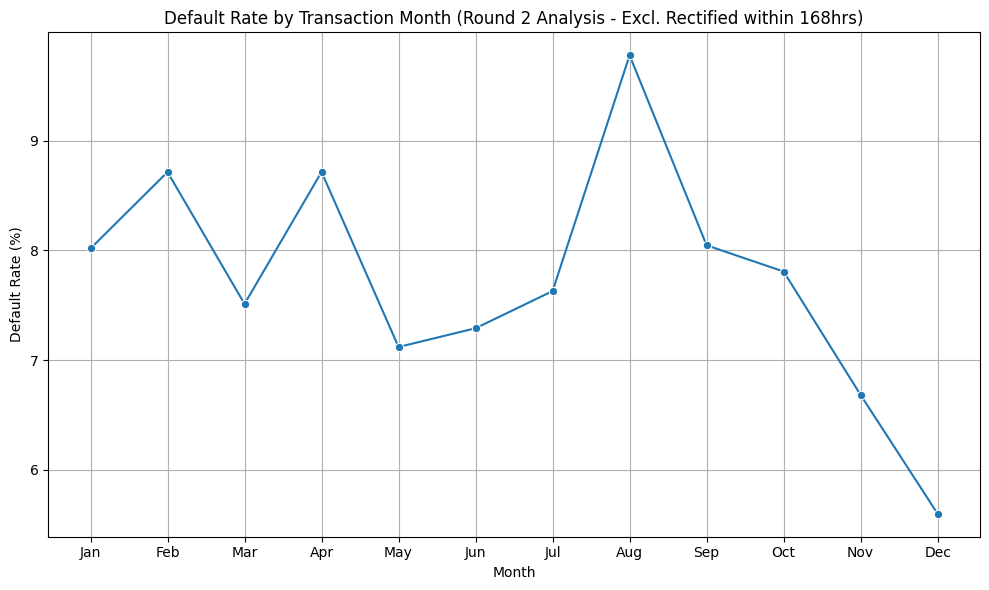


Default rates by Quarter (Round 2 Analysis - Excl. Rectified within 168hrs):
| transaction_quarter   | total_transactions   | defaults   | default_rate   |
|:----------------------|:---------------------|:-----------|:---------------|
| 1                     | 5693                 | 460        | 8.0801         |
| 2                     | 7171                 | 551        | 7.68373        |
| 3                     | 7541                 | 620        | 8.22172        |
| 4                     | 5154                 | 346        | 6.71323        |


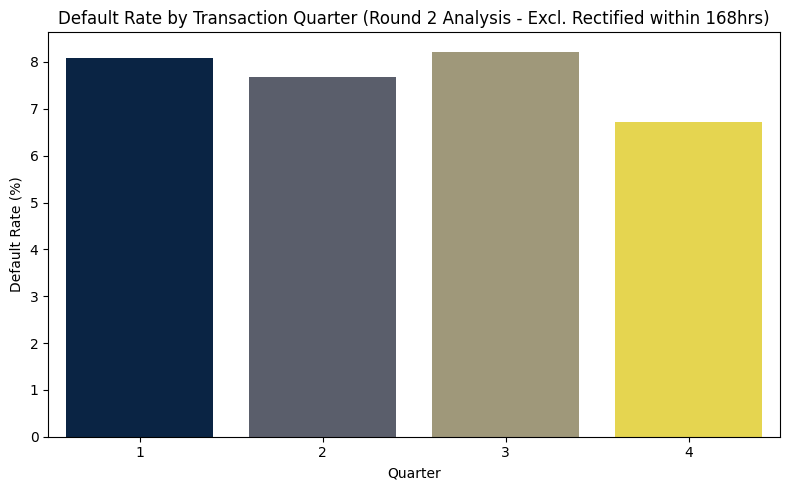


Default rates by Payment Lag Group (Round 2 Analysis - Excl. Rectified within 168hrs):
| payment_lag_group     | total_transactions   | defaults   | default_rate   |
|:----------------------|:---------------------|:-----------|:---------------|
| 180+ Days             | 5                    | 3          | 60             |
| 91-180 Days           | 12                   | 4          | 33.3333        |
| 1-7 Days              | 3372                 | 1040       | 30.8422        |
| Same Day/Prev Day (0) | 12596                | 908        | 7.20864        |
| 61-90 Days            | 37                   | 2          | 5.40541        |
| 8-14 Days             | 434                  | 5          | 1.15207        |
| 31-60 Days            | 2757                 | 4          | 0.145085       |
| 15-30 Days            | 4703                 | 3          | 0.0637891      |


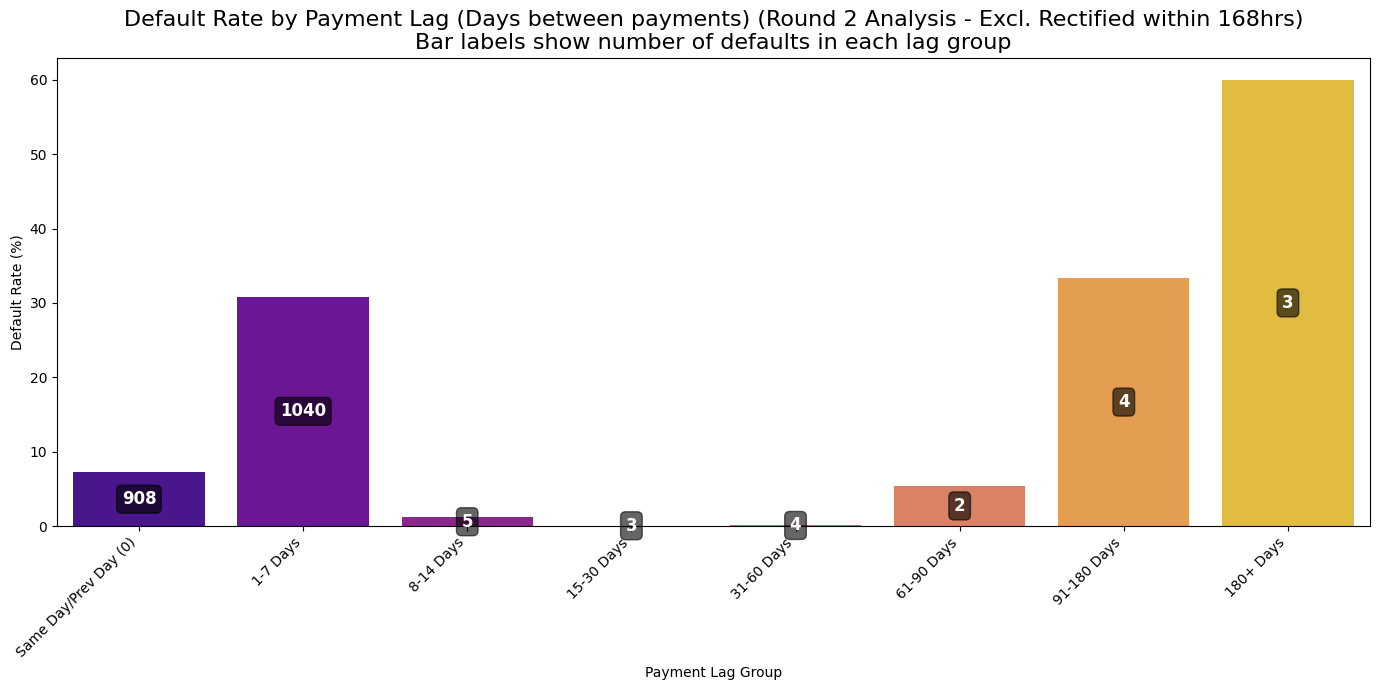

In [87]:
# ### Re-analyzing Default Rates by Entity Type

# %%
entity_type_defaults_round2 = merged_df_round2.groupby('entity_type').agg(
    total_transactions=('is_default_round2', 'count'),
    defaults=('is_default_round2', 'sum')
).reset_index()
entity_type_defaults_round2['default_rate'] = (entity_type_defaults_round2['defaults'] / entity_type_defaults_round2['total_transactions']) * 100
entity_type_defaults_round2 = entity_type_defaults_round2.sort_values(by='default_rate', ascending=False)

print("\nDefault rates by Entity Type (Round 2 Analysis - Excl. Rectified within 168hrs):")
print(entity_type_defaults_round2.to_markdown(index=False, numalign="left", stralign="left"))

plt.figure(figsize=(12, 6))
sns.barplot(x='entity_type', y='default_rate', data=entity_type_defaults_round2, hue='entity_type', palette='viridis', legend=False)
plt.title(f'Default Rate by Entity Type (Round 2 Analysis - Excl. Rectified within {constant_hours_threshold}hrs)')
plt.xlabel('Entity Type')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# %% [markdown]
# ### Re-analyzing Default Rates by Client Age Group

# %%
# Re-create client_age_group in merged_df_round2 to ensure consistency with initial analysis
# (even though it should already be there, good practice for self-contained blocks)
age_bins_round2 = [0, 4, 7, 10, 13, 16, 19, float('inf')]
age_labels_round2 = ["0-3 Years", "4-6 Years", "7-9 Years", "10-12 Years", "13-15 Years", "16-18 Years", "19+ Years"]

merged_df_round2['client_age_group'] = pd.cut(
    merged_df_round2['client_age_at_transaction'],
    bins=age_bins_round2,
    labels=age_labels_round2,
    right=False
)

age_group_defaults_round2 = merged_df_round2.groupby('client_age_group', observed=True).agg(
    total_transactions=('is_default_round2', 'count'),
    defaults=('is_default_round2', 'sum')
).reset_index()
age_group_defaults_round2['default_rate'] = (age_group_defaults_round2['defaults'] / age_group_defaults_round2['total_transactions']) * 100
age_group_defaults_round2 = age_group_defaults_round2.sort_values(by='default_rate', ascending=False)

print(f"\nDefault rates by Client Age Group (Round 2 Analysis - Excl. Rectified within {constant_hours_threshold}hrs):")
print(age_group_defaults_round2.to_markdown(index=False, numalign="left", stralign="left"))

plt.figure(figsize=(8, 6))
sns.barplot(x='client_age_group', y='default_rate', data=age_group_defaults_round2, hue='client_age_group', palette='viridis', legend=False, dodge=False)
plt.title(f'Default Rate by Client Age Group at Transaction (Round 2 Analysis - Excl. Rectified within {constant_hours_threshold}hrs)')
plt.xlabel('Client Age Group')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# %% [markdown]
# ### Re-analyzing Temporal Defaults (Month & Quarter)

# %%
# Monthly Defaults
monthly_defaults_round2 = merged_df_round2.groupby('transaction_month').agg(
    total_transactions=('is_default_round2', 'count'),
    defaults=('is_default_round2', 'sum')
).reset_index()
monthly_defaults_round2['default_rate'] = (monthly_defaults_round2['defaults'] / monthly_defaults_round2['total_transactions']) * 100

print(f"\nDefault rates by Month (Round 2 Analysis - Excl. Rectified within {constant_hours_threshold}hrs):")
print(monthly_defaults_round2.sort_values(by='transaction_month').to_markdown(index=False, numalign="left", stralign="left"))

plt.figure(figsize=(10, 6))
sns.lineplot(x='transaction_month', y='default_rate', data=monthly_defaults_round2, marker='o')
plt.title(f'Default Rate by Transaction Month (Round 2 Analysis - Excl. Rectified within {constant_hours_threshold}hrs)')
plt.xlabel('Month')
plt.ylabel('Default Rate (%)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()

# Quarterly Defaults
quarterly_defaults_round2 = merged_df_round2.groupby('transaction_quarter').agg(
    total_transactions=('is_default_round2', 'count'),
    defaults=('is_default_round2', 'sum')
).reset_index()
quarterly_defaults_round2['default_rate'] = (quarterly_defaults_round2['defaults'] / quarterly_defaults_round2['total_transactions']) * 100

print(f"\nDefault rates by Quarter (Round 2 Analysis - Excl. Rectified within {constant_hours_threshold}hrs):")
print(quarterly_defaults_round2.sort_values(by='transaction_quarter').to_markdown(index=False, numalign="left", stralign="left"))

plt.figure(figsize=(8, 5))
sns.barplot(x='transaction_quarter', y='default_rate', data=quarterly_defaults_round2, hue='transaction_quarter', palette='cividis', legend=False)
plt.title(f'Default Rate by Transaction Quarter (Round 2 Analysis - Excl. Rectified within {constant_hours_threshold}hrs)')
plt.xlabel('Quarter')
plt.ylabel('Default Rate (%)')
plt.tight_layout()
plt.show()


# %% [markdown]
# ### Re-analyzing Default Rates by Payment Lag Group

# %%
# Create lag bins for merged_df_round2
lag_bins_round2 = [-1, 0, 7, 14, 30, 60, 90, 180, merged_df_round2['payment_lag_days'].max() + 1]
lag_labels_round2 = ['Same Day/Prev Day (0)', '1-7 Days', '8-14 Days', '15-30 Days', '31-60 Days', '61-90 Days', '91-180 Days', '180+ Days']

# Exclude NaN values from payment_lag_days as they are first payments of a contract
lag_analysis_df_round2 = merged_df_round2.dropna(subset=['payment_lag_days']).copy()
lag_analysis_df_round2['payment_lag_group'] = pd.cut(
    lag_analysis_df_round2['payment_lag_days'],
    bins=lag_bins_round2,
    labels=lag_labels_round2,
    right=True
)

lag_defaults_round2 = lag_analysis_df_round2.groupby('payment_lag_group', observed=False).agg(
    total_transactions=('is_default_round2', 'count'),
    defaults=('is_default_round2', 'sum')
).reset_index()
lag_defaults_round2['default_rate'] = (lag_defaults_round2['defaults'] / lag_defaults_round2['total_transactions']) * 100

print(f"\nDefault rates by Payment Lag Group (Round 2 Analysis - Excl. Rectified within {constant_hours_threshold}hrs):")
print(lag_defaults_round2.sort_values(by='default_rate', ascending=False).to_markdown(index=False, numalign="left", stralign="left"))

plt.figure(figsize=(14, 7))
ax_round2 = sns.barplot(
    x='payment_lag_group',
    y='default_rate',
    data=lag_defaults_round2,
    hue='payment_lag_group',
    palette='plasma',
    legend=False
)
plt.title(f'Default Rate by Payment Lag (Days between payments) (Round 2 Analysis - Excl. Rectified within {constant_hours_threshold}hrs)\nBar labels show number of defaults in each lag group', fontsize=16)
plt.xlabel('Payment Lag Group')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Annotate each bar with the raw frequency (defaults)
for i, row in lag_defaults_round2.iterrows():
    ax_round2.text(
        i,
        row['default_rate'] / 2,
        f"{int(row['defaults'])}",
        ha='center', va='center',
        color='white', fontweight='bold', fontsize=12,
        bbox=dict(facecolor='black', alpha=0.6, boxstyle='round,pad=0.3')
    )

plt.show()